In [1]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import zscore
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


The points distribution for this case is as follows:

Read the dataset
Drop the columns which are unique for all users like IDs (2.5 points)
Distinguish the feature and target set (2.5 points)
Divide the data set into Train and test sets
Normalize the train and test data (2.5 points)
Initialize & build the model (10 points)
Optimize the model (5 points)
Predict the results using 0.5 as a threshold (5 points)
Print the Accuracy score and confusion matrix (2.5 points)

In [0]:
1. Read the dataset

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [24]:
file_list = drive.ListFile({'q': "'1x-EdUOPUoh1-lGaDCMK1yw8jmbf6-izm' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Untitled1.ipynb, id: 1ax-XxbVsWySGf2bhYJZr8fmvC0p4rnfv
title: bank.csv, id: 1bJlQYyltro9s4kUTj6IlEmNUSbeclMnc
title: Untitled0.ipynb, id: 1M_KtU1J9SkRK9T5JRI_HhdyFk5R3unvH
title: prices.csv, id: 1k4gY0JICfhUj0Q2h-1z0_UQSUrY8PDE-


In [0]:
file_downloaded = drive.CreateFile({'id': '1bJlQYyltro9s4kUTj6IlEmNUSbeclMnc'})
file_downloaded.GetContentFile('bank.csv')

In [27]:
# load the dataset
df_bank = pd.read_csv("bank.csv")
print("Shape: ",df_bank.shape)
df_bank.head()

Shape:  (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [28]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [29]:

# check missing values..
df_bank.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [30]:
# numbers of unique users
print("Unique RowNumber: ", len(df_bank.RowNumber.unique()))

# numbers of unique products
print("Unique CustomerId ", len(df_bank.CustomerId.unique()))

# numbers of unique products
print("Unique Surname ", len(df_bank.Surname.unique()))

Unique RowNumber:  10000
Unique CustomerId  10000
Unique Surname  2932


2. Drop the columns which are unique for all users like IDs (2.5 points)

In [0]:
# Dropping the columns which are unique for all users
drop_attrs = ["RowNumber", "CustomerId", "Surname"]
df_bank.drop(labels=drop_attrs,axis=1,inplace=True)

In [32]:
print("Shape: ",df_bank.shape)
df_bank.head()

Shape:  (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
# utilify function for % distribution
def category_distribution(df, colname):
    col_data = df[colname].value_counts().to_frame()
    col_data.reset_index(inplace=True)
    col_data.columns = [col_data.columns[1], 'count']
    col_data['proportions'] = col_data['count'] / sum(col_data['count'])
    print("\n % Distribution for: ",colname)
    print("\n", col_data)
    return

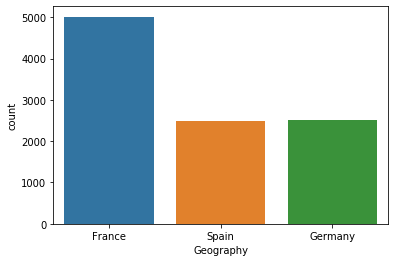


 % Distribution for:  Geography

   Geography  count  proportions
0    France   5014       0.5014
1   Germany   2509       0.2509
2     Spain   2477       0.2477


In [34]:
# plotting count of Geography
sns.countplot(data=df_bank , x='Geography')
plt.show()

category_distribution(df_bank, "Geography")

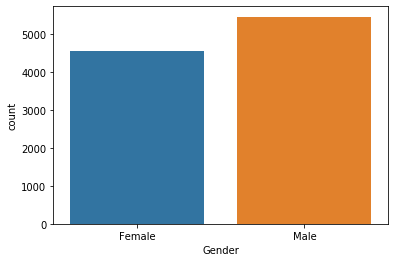


 % Distribution for:  Gender

    Gender  count  proportions
0    Male   5457       0.5457
1  Female   4543       0.4543


In [35]:
# plotting count of Gender
sns.countplot(data=df_bank , x='Gender')
plt.show()

category_distribution(df_bank, "Gender")

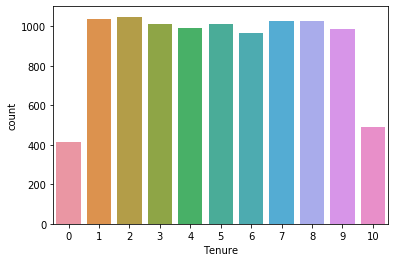


 % Distribution for:  Tenure

     Tenure  count  proportions
0        2   1048       0.1048
1        1   1035       0.1035
2        7   1028       0.1028
3        8   1025       0.1025
4        5   1012       0.1012
5        3   1009       0.1009
6        4    989       0.0989
7        9    984       0.0984
8        6    967       0.0967
9       10    490       0.0490
10       0    413       0.0413


In [36]:
# plotting count of NumOfProducts
sns.countplot(data=df_bank , x='Tenure')
plt.show()

category_distribution(df_bank, "Tenure")

In [0]:
numerical_cols = ["CreditScore", "Balance", "EstimatedSalary"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f367d05f8>,
      dtype=object)

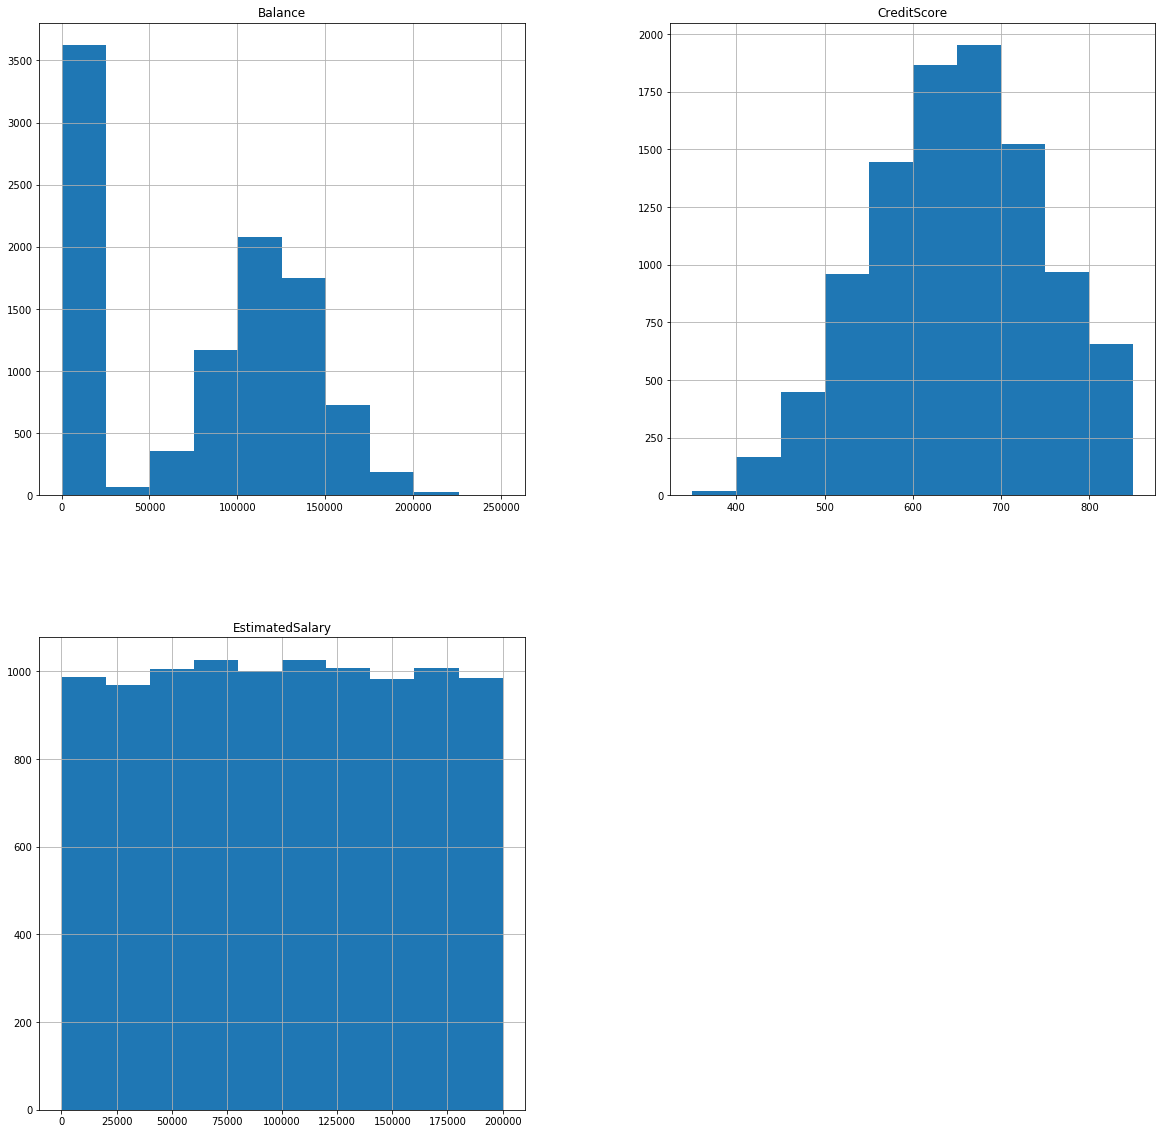

In [38]:
# perform univariant analysis by generating histogram of all dimensions
df_bank[numerical_cols].hist(figsize = [20,20])


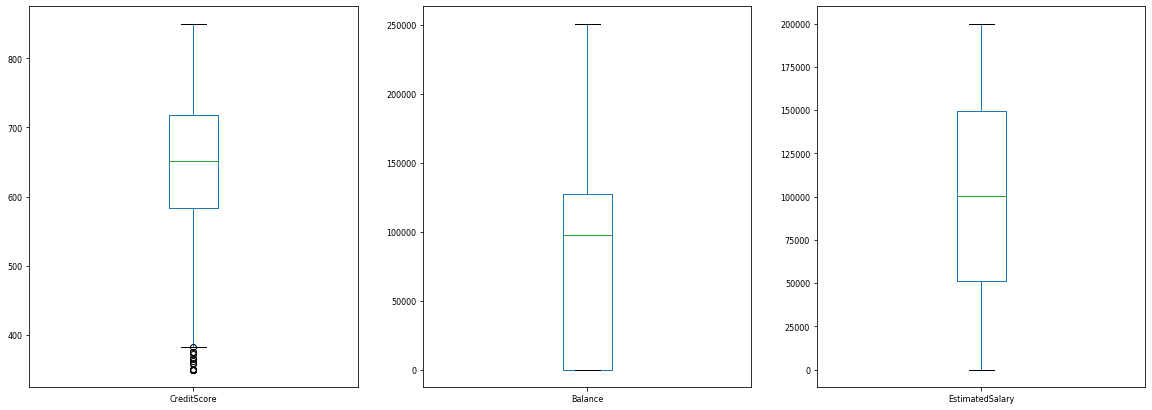

In [39]:
df_bank[numerical_cols].plot(kind='box', subplots=True, layout=(1,3), fontsize=8, figsize=(20,7))
plt.show()

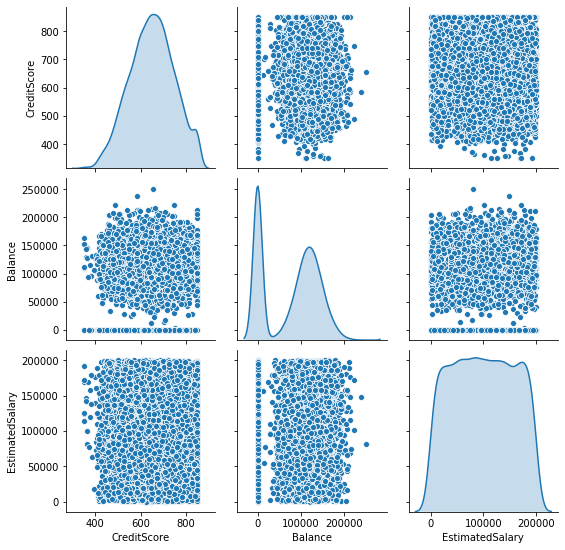

In [40]:
# bivariable analysis
sns.pairplot(df_bank[numerical_cols], diag_kind="kde")

In [41]:
# % of dateset having Balance as zero
bal_zero = len(df_bank[df_bank["Balance"]==0])/df_bank.shape[0]
print("% of dataset having zero balance: ", bal_zero)

% of dataset having zero balance:  0.3617


In [0]:
# Analysing independent variable correlation with each other and target variable
corr_matrix = df_bank.corr()

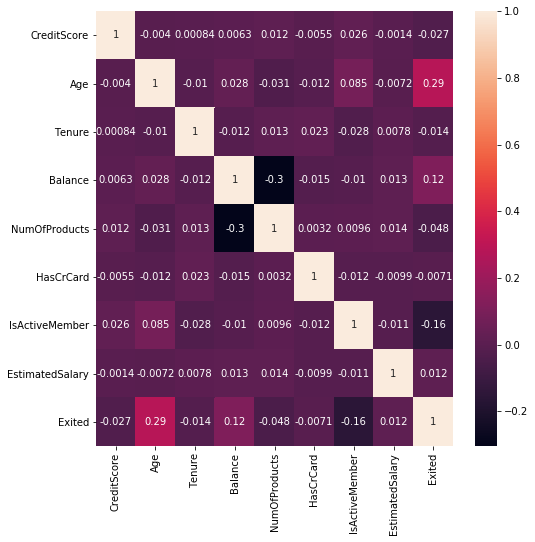

In [43]:

plt.subplots(figsize = (8,8))
sns.heatmap(corr_matrix, annot=True)

Dropped Attributes

Following attributes are uniques to the users and dropped from analysis: "RowNumber", "CustomerId", "Surname"
Observation on categorical attributes "Geography", "Gender", "Tenure","NumOfProducts", "HasCrCard", "IsActiveMember"

NumOfProducts: there are 4 unique values(1,2,3,4_. value of 3,4 contibutes only 2.6 % and 0.6%
"Geography", "Gender": are non-numeric data categorical attribute and hence required label encoding
Observations on continuous attributes ("CreditScore", "Balance", "EstimatedSalary")

"Balance" attributes: approx 36% of dataset contains values of zero. two gausian curve are observed which might indicates two data sources or existing of clusters
"CreditScore" attribute: outliers exist in lower side.
Scaling is required as all three attribuets have different ranges

Traget calss: Exited

Target class is not balanced. Non-Exited contribute majority of class around 79%

In [0]:

#Convert categorical text into categorical numbers
# converts categorical text into categorical numbers.
labelencoder = LabelEncoder()
df_bank['Geography'] = labelencoder.fit_transform(df_bank['Geography'])
df_bank['Gender'] = labelencoder.fit_transform(df_bank['Gender'])

In [45]:
df_bank.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [46]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null int64
Gender             10000 non-null int64
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9)
memory usage: 859.5 KB


In [0]:
# function to replace upper outlier with their max value of (Q3 + 1.5 * IRQ)
def treat_upper_outliers(df, colname):
    data = df[colname]
    irq = np.quantile(a=data,q=0.75)-np.quantile(a=data,q=0.25)
    ub = np.quantile(a=data,q=0.75) + 1.5 * irq
    df[colname] = df[colname].apply(lambda x: ub if x > ub else x)
    
# function to replace lower outlier with their min value of (Q1 - 1.5 * IRQ)
def treat_lower_outliers(df, colname):
    data = df[colname]
    irq = np.quantile(a=data,q=0.75)-np.quantile(a=data,q=0.25)
    lb = np.quantile(a=data,q=0.25) - 1.5 * irq
    df[colname] = df[colname].apply(lambda x: lb if x < lb else x)

In [0]:
df_bank_treated = df_bank.copy(deep = True)  # make copy of orignal dataframe

# outlier treatment for "CreditScore"
treat_lower_outliers(df_bank_treated, "CreditScore")

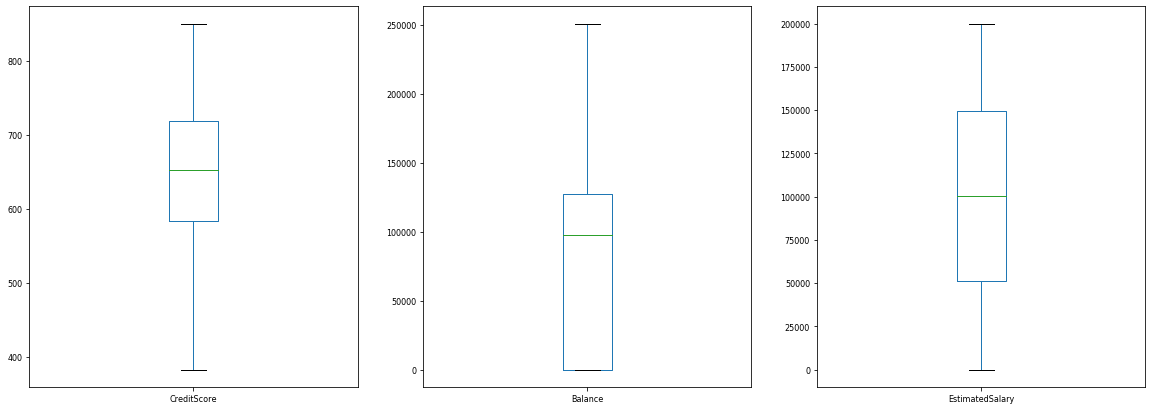

In [49]:
df_bank_treated[numerical_cols].plot(kind='box', subplots=True, layout=(1,3), fontsize=8, figsize=(20,7))
plt.show()

In [50]:
print("Shape: ", df_bank_treated.shape)
df_bank_treated.head()

Shape:  (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,0,0,42,2,0.00,1,1,1,101348.88,1
1,608.0,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502.0,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699.0,0,0,39,1,0.00,2,0,0,93826.63,0
4,850.0,2,0,43,2,125510.82,1,1,1,79084.10,0


In [0]:
category_attrs=["Geography", "Gender", "Tenure","NumOfProducts", "HasCrCard", "IsActiveMember"]

df_bank_treated = pd.get_dummies(df_bank_treated, columns=category_attrs)

In [52]:
print("Shape: ", df_bank_treated.shape)
df_bank_treated.head()

Shape:  (10000, 29)


,CreditScore,Age,Balance,EstimatedSalary,Exited,Geography_0,Geography_1,Geography_2,Gender_0,Gender_1,Tenure_0,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619.0,42,0.00,101348.88,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
1,608.0,41,83807.86,112542.58,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
2,502.0,42,159660.80,113931.57,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0
3,699.0,39,0.00,93826.63,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
4,850.0,43,125510.82,79084.10,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


NOTE:
df_bank: dataset without outlier handing and withotu one-hot coding

df_bank_treated: dataset with outlier handing and one-hot coding

3. Distinguish the feature and target set (2.5 points)

In [0]:
df_target = df_bank[["Exited"]]
df_features = df_bank.drop(labels="Exited",axis=1)

In [54]:
df_features.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


4. Divide the data set into Train and test sets

In [0]:
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size=test_size, random_state=seed)

In [56]:
print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)

X_train:  (7000, 10)
Y_train:  (7000, 1)


In [57]:
print("X_test: ", X_test.shape)
print("Y_test: ", Y_test.shape)

X_test:  (3000, 10)
Y_test:  (3000, 1)


5. Normalize the train and test data (2.5 points)

In [0]:
# Normalized variables: 
# Transform (centralize) the entire (independent variable data) to zscores through transformation.
std_scale = StandardScaler()
X_train_std = std_scale.fit_transform(X_train)
X_test_std = std_scale.fit_transform(X_test)

6. Initialize & build the model (10 points)

In [59]:
#Initialize Sequential model
model1 = keras.models.Sequential()

#input_dim is required for the first hidden layer, as it is the first starting point. --> number of inputs.
model1.add(keras.layers.BatchNormalization(input_shape=(X_train_std.shape[1],)))

# Output Layer
# output_dim should be 1, as output is binary outcome, and activation should be 'sigmoid'
# Keras declares weights and bias automatically
model1.add(keras.layers.Dense(1, activation='sigmoid'))

In [60]:
#compile the model --> backpropagation -> gradient descent
#optimizer = algorithm to find the optimal set of weights in ANN
#loss = functions that should be optimized.
#metrics = criterion used to calculate the performance of the model.
model1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [61]:
#batch_size = the number of observations after which you want to update the weights
#           batch size and epochs should be tuned through experiments.
#epoch = going through the whole dataset
model1.fit(X_train_std, Y_train, 
          validation_data=(X_test_std, Y_test), 
          epochs=30,
          batch_size=10)




Train on 7000 samples, validate on 3000 samples
Epoch 1/30





7000/7000 [==============================] - 2s 239us/step - loss: 0.5311 - acc: 0.7520 - val_loss: 0.4596 - val_acc: 0.8077
Epoch 2/30
7000/7000 [==============================] - 1s 147us/step - loss: 0.4515 - acc: 0.8057 - val_loss: 0.4410 - val_acc: 0.8113
Epoch 3/30
7000/7000 [==============================] - 1s 151us/step - loss: 0.4429 - acc: 0.8056 - val_loss: 0.4361 - val_acc: 0.8160
Epoch 4/30
7000/7000 [==============================] - 1s 143us/step - loss: 0.4366 - acc: 0.8121 - val_loss: 0.4344 - val_acc: 0.8137
Epoch 5/30
7000/7000 [==============================] - 1s 146us/step - loss: 0.4338 - acc: 0.8163 - val_loss: 0.4333 - val_acc: 0.8123
Epoch 6/30
7000/7000 [==============================] - 1s 152us/step - loss: 0.4396 - acc: 0.8086 - val_loss: 0.4332 - val_acc: 0.8123
Epoch 7/30
7000/7000 [==============================] - 1s 142us/step - loss: 0.4378 - acc: 0.8107 - val_loss: 0.4330 - val_acc:

In [62]:

test_loss1, test_acc1 = model1.evaluate(X_test_std, Y_test)
print('\nTest accuracy:[Without any middle layer]: %0.2f' %(test_acc1*100))

3000/3000 [==============================] - 0s 27us/step

Test accuracy:[Without any middle layer]: 81.20



7. Optimize the model (5 points)
Build optimized model using treated dataset and with diffferent graph having multiple middle layer and neurons

Below model is create after various iteration and experiment with different middle layers and neurons and finally selected model with following graph giving better accuracy

Graph:

input layer -> 3 middle layers having 6 neuron each and with actication=relu -> output layer with activation=sigmoid
build with optimizer="adam"
executed with epochs=50, batch_size=50
finally plotted Train and Test accuracy for each epoc to verify if model does not overfit

In [63]:
df_target = df_bank_treated[["Exited"]]
df_features = df_bank_treated.drop(labels="Exited",axis=1)

# Divide the data set into Train and test sets
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size=test_size, random_state=seed)

print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", Y_test.shape)

#Normalize the train and test data
# Normalized variables: 
# Transform (centralize) the entire (independent variable data) to zscores through transformation.
std_scale = StandardScaler()
X_train_std = std_scale.fit_transform(X_train)
X_test_std = std_scale.fit_transform(X_test)

# input size
print("Input Dimension: %d" %(X_train_std.shape[1]))

# Output size
print("Output Dimension: %d" %(Y_train.shape[1]))

X_train:  (7000, 28)
Y_train:  (7000, 1)
X_test:  (3000, 28)
Y_test:  (3000, 1)
Input Dimension: 28
Output Dimension: 1


In [0]:
model2 = keras.models.Sequential()

# Keras declares weights and bias automatically
#input_dim is required for the first hidden layer, as it is the first starting point. --> number of inputs.
#Normalize input data
model2.add(keras.layers.BatchNormalization(input_shape=(X_train_std.shape[1],)))

model2.add(keras.layers.Dense(6, activation='relu'))
model2.add(keras.layers.Dense(6, activation='relu'))
model2.add(keras.layers.Dense(6, activation='relu'))

# Output Layer
# output_dim should be 1, as output is binary outcome, and activation should be 'sigmoid'
# Keras declares weights and bias automatically
model2.add(keras.layers.Dense(output_dim = 1, activation='sigmoid'))

In [0]:
#compile the model --> backpropagation -> gradient descent
#optimizer = algorithm to find the optimal set of weights in ANN
#loss = functions that should be optimized.
#metrics = criterion used to calculate the performance of the model.
model2.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
#batch_size = the number of observations after which you want to update the weights
#           batch size and epochs should be tuned through experiments.
#epoch = going through the whole dataset
history = model2.fit(X_train_std, Y_train, 
          validation_data=(X_test_std, Y_test), 
          epochs=50,
          batch_size=50)

Train on 7000 samples, validate on 3000 samples
Epoch 1/50
7000/7000 [==============================] - 1s 105us/step - loss: 0.5463 - acc: 0.7857 - val_loss: 0.4623 - val_acc: 0.7983
Epoch 2/50
7000/7000 [==============================] - 0s 35us/step - loss: 0.4427 - acc: 0.7973 - val_loss: 0.4202 - val_acc: 0.8093
Epoch 3/50
7000/7000 [==============================] - 0s 38us/step - loss: 0.4075 - acc: 0.8201 - val_loss: 0.3925 - val_acc: 0.8280
Epoch 4/50
7000/7000 [==============================] - 0s 38us/step - loss: 0.3872 - acc: 0.8326 - val_loss: 0.3796 - val_acc: 0.8360
Epoch 5/50
7000/7000 [==============================] - 0s 36us/step - loss: 0.3791 - acc: 0.8387 - val_loss: 0.3732 - val_acc: 0.8407
Epoch 6/50
7000/7000 [==============================] - 0s 41us/step - loss: 0.3762 - acc: 0.8396 - val_loss: 0.3693 - val_acc: 0.8447
Epoch 7/50
7000/7000 [==============================] - 0s 40us/step - loss: 0.3658 - acc: 0.8461 - val_loss: 0.3661 - val_acc: 0.8483
Epoch 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


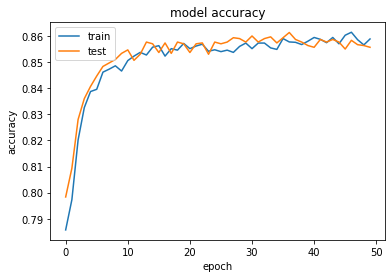

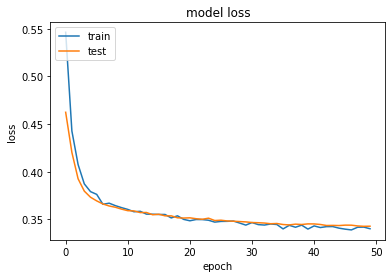

In [67]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
test_loss2, test_acc2 = model2.evaluate(X_test_std, Y_test)
print('\nTest accuracy:[With middle layer]: %0.2f' %(test_acc2*100))

3000/3000 [==============================] - 0s 26us/step

Test accuracy:[With middle layer]: 85.57



8. Predict the results using 0.5 as a threshold (5 points)

In [69]:
# predict the model
y_predict = model2.predict(X_test_std)
y_predict

array([[0.7372677 ],
       [0.09656298],
       [0.02033985],
       ...,
       [0.00358114],
       [0.03445479],
       [0.20893118]], dtype=float32)

In [70]:
# keeping 0.5 as a threshold 
y_predict = (y_predict > 0.5) #to classify each probability into True or False
y_predict

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

9. Print the Accuracy score and confusion matrix (2.5 points

In [71]:
test_acc = metrics.accuracy_score(Y_test,y_predict)
print('\nTest accuracy:[With customized sgd with threshold as 0.5]: %0.2f' %(test_acc*100))


Test accuracy:[With customized sgd with threshold as 0.5]: 85.57


In [72]:
print("Confusion matrix:")
metrics.confusion_matrix(Y_test, y_predict)

Confusion matrix:


array([[2321,   74],
       [ 359,  246]])

In [74]:
cr = metrics.classification_report(Y_test,y_predict)

print("Classification Report: \n\n", cr)

Classification Report: 

               precision    recall  f1-score   support

           0       0.87      0.97      0.91      2395
           1       0.77      0.41      0.53       605

    accuracy                           0.86      3000
   macro avg       0.82      0.69      0.72      3000
weighted avg       0.85      0.86      0.84      3000



In [0]:
ROC curve to choose a threshold that balances sensitivity and specificity

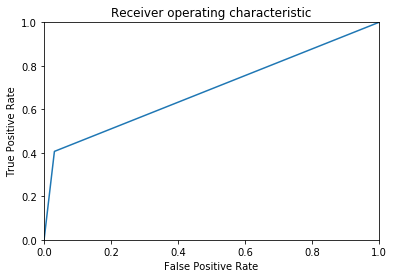

In [76]:
fpr,tpr, thresholds = metrics.roc_curve(Y_test, y_predict)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [77]:
roc_auc = metrics.auc(fpr, tpr)
print('Area Under the curve',roc_auc)

Area Under the curve 0.6878569333494367


In [0]:

# save the model
model2.save('bank_customer.h5')